In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

In [52]:
DATA_ROOT = "../data/"
READDIR_ROOT = os.path.join(DATA_ROOT, 'processed')
FIGURES_ROOT = '../figures/'
MODELS_ROOT = '../models/logistic'

readfile = os.path.join(READDIR_ROOT, 'model-data-mobile-payment.csv')
readfile_train = os.path.join(READDIR_ROOT, 'model-data-train.csv')
readfile_test = os.path.join(READDIR_ROOT, 'model-data-test.csv')


print(readfile)
print(readfile_train)
print(readfile_test)

../data/processed/model-data-mobile-payment.csv
../data/processed/model-data-train.csv
../data/processed/model-data-test.csv


In [53]:
# mkdir for saving figures if it doesn't already exist
if not os.path.exists(FIGURES_ROOT):
    os.mkdir(FIGURES_ROOT)
    
# mkdir for saving output data if it doesn't already exist
if not os.path.exists(MODELS_ROOT):
    os.mkdir(MODELS_ROOT)

In [3]:
df_data = pd.read_csv(readfile)
df_train = pd.read_csv(readfile_train)
df_test = pd.read_csv(readfile_test)

df_data.info()
df_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1872 entries, 0 to 1871
Data columns (total 36 columns):
r_weight          1872 non-null float64
pa051_a           1872 non-null float64
pa051_b           1872 non-null float64
pa027_a           1872 non-null float64
pa027_b           1872 non-null float64
pa027_c           1872 non-null float64
pa027_d           1872 non-null float64
pa027_e           1872 non-null float64
pa026             1872 non-null float64
age               1872 non-null float64
edu_lhs           1872 non-null int64
edu_hs            1872 non-null int64
edu_sc            1872 non-null int64
edu_c             1872 non-null int64
edu_pgs           1872 non-null int64
inc_lt25          1872 non-null float64
inc_2549          1872 non-null float64
inc_5074          1872 non-null float64
inc_7599          1872 non-null float64
inc_100124        1872 non-null float64
inc_125199        1872 non-null float64
inc_gt200         1872 non-null float64
MPay_label        1872 

,r_weight,pa051_a,pa051_b,pa027_a,pa027_b,pa027_c,pa027_d,pa027_e,pa026,age,...,IncLevel_label,AgeLevel_label,white_label,MPay,CPay,MBank,EdLevel,IncLevel,AgeLevel,white
0,48.407444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.0,...,"Less than $25,000",55-64 years,Yes,0,0,0,2,1,5,1
1,19.693514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,...,"$25,000-$49,999 per year",55-64 years,Yes,0,0,0,3,2,5,1
2,27.521273,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,70.0,...,"$25,000-$49,999 per year",More than 65,Yes,0,1,1,3,2,6,1
3,21.771318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63.0,...,"$100,000-$124,999 per year",55-64 years,Yes,0,0,0,3,5,5,1
4,12.004013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,52.0,...,"$75,000-$99,999 per year",45-54 years,Yes,0,0,0,5,4,4,1


In [22]:
predictor_cols = df_data.iloc[:,30:].columns
predictor_label_cols = list(df_data.iloc[:,23:29].columns)
response_col = 'MPay'
response_label_col = 'MPay_label'
weights_col = 'r_weight'

In [44]:
X_data = df_data[predictor_cols].copy()
y_data = df_data[response_col].copy()
X_train = df_train[predictor_cols].copy()
X_test = df_test[predictor_cols].copy()
y_train = df_train[response_col].values.ravel()
y_test = df_test[response_col].values.ravel()
weights_data = df_data[weights_col].values.ravel()
weights_train = df_train[weights_col].values.ravel()
weights_test = df_test[weights_col].values.ravel()

print(X_data.shape, y_data.shape)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(weights_data.shape, weights_train.shape, weights_test.shape)

(1872, 6) (1872,)
(1123, 6) (749, 6)
(1123,) (749,)
(1872,) (1123,) (749,)


In [45]:
####################################################################
# DEFINE FUNCTIONS THAT CONTRIBUTE TO GENERATING A FITTED MODEL DICT 
####################################################################

def summarize_predictions(predictions_train, predictions_test):
    """
    Generates a summary table of the training and test predictions, showing count
    and proportion by class
    
    predictions_train: np.array, the predicted classes generated on the training data
    predictions_test:np.array, the predicted classes generated on the test data
    
    returns: tuple of 2 pd.DataFrame objects, one summarizing the training predictions
             the other summarizing the test predictions
    """
    frame_name_list = ['pred_counts_train', 'pred_counts_test']
    
    for predictions, name in zip(
        [predictions_train, predictions_test],
        frame_name_list
    ):
        locals()[name] = np.array(np.unique(predictions, return_counts=True)).T
        locals()[name] = np.hstack(
            [locals()[name], locals()[name][:,1].reshape(-1,1)/np.sum(locals()[name][:,1])]
        )
        locals()[name] = pd.DataFrame(locals()[name], columns=['class', 'count', 'proportion'])
        locals()[name][['class', 'count']] = locals()[name][['class', 'count']].astype(int)
        locals()[name] = locals()[name].set_index('class')

    return locals()[frame_name_list[0]], locals()[frame_name_list[1]]


def make_conf_matrix(predictions, y_actual):
    """
    Generates a confusion matrix of actual classes versus predicted classes
    
    predictions: np.array, predicted class values generated by the model
    y_actual: np.array, actual class values
    
    returns: pd.DataFrame, the resulting confusion matrix with marginal totals included
    """
    class_labels = sorted(list(set(y_actual)))
    
    conf_matrix = pd.DataFrame(confusion_matrix(predictions, y_actual), columns=class_labels)
    conf_matrix.index.name = 'Predicted'
    conf_matrix.columns.name = 'Actual'
    conf_matrix.loc['Total'] = conf_matrix.sum(axis=0)
    conf_matrix['Total'] = conf_matrix.sum(axis=1)
    
    return conf_matrix


def generate_class_metrics(conf_matrix):
    """
    Generates a dataframe of the various by-class classification metrics that
    can be calculated directly from a confusion matrix, such as True Positive Rate,
    False Negative Rate, etc.
    
    conf_matrix: pd.DataFrame, generated with the make_conf_matrix function
    
    returns: pd.DataFrame, each row representing a different class, each
             column a different classification metric for each class
    """
    # rename index
    conf_matrix = conf_matrix.copy()
    conf_matrix.index.name = 'class'
    conf_matrix.columns.name = 'class'
    results = dict()
    
    # True Pos, False Pos, False Neg, True Neg counts
    results['TP'] = pd.Series(np.diag(conf_matrix.iloc[:-1,:-1]))
    results['TP'].index.name = 'class'
    results['FP'] = conf_matrix.iloc[:-1,:-1].sum(axis=1) - results['TP']  
    results['FN'] = conf_matrix.iloc[:-1,:-1].sum(axis=0) - results['TP']
    results['TN'] = conf_matrix.iloc[:-1,:-1].values.sum() -\
                    (results['FP'] + results['FN'] + results['TP'])

    # true positive rate
    results['TPR'] = results['TP']/(results['TP']+results['FN'])
    # false negative rate
    results['FNR'] = results['FN']/(results['TP']+results['FN'])
    # false positive rate
    results['FPR'] = results['FP']/(results['FP']+results['TN'])
    # true negative rate
    results['TNR'] = results['TN']/(results['TN']+results['FP']) 
    # positive predictive value
    results['PPV'] = results['TP']/(results['TP']+results['FP'])
    # negative predictive value
    results['NPV'] = results['TN']/(results['TN']+results['FN'])
    # F1 score
    results['F1'] = 2*((results['PPV']*results['TPR'])/(results['PPV']+results['TPR']))
    
    # convert results dictionary to a dataframe 
    results_df = pd.concat(
        [
            # first separate the integer values so they format correctly
            pd.DataFrame(
                list(results.values())[:4],
                index=list(results.keys())[:4]
            ).T,
            # followed by the float values
            pd.DataFrame(
                list(results.values())[4:],
                index=list(results.keys())[4:]
            ).T
        ], axis=1
    )
    
    return results_df.fillna(0)


def generate_roc_auc(y_values_actual, predicted_probabilities, class_dict):
    """
    Creates a dictionary of ROC curve values generated using
    sklearn.metrics.roc_curve for every outcome class in a multi-class
    problem
    
    NOTE: multi-class AUC requires scikit-learn>=v0.22

    y_values_actual: np.array, the 1-dimensional array containing the 
                     multi-classs true y values against which you are evaluating
                     the predicted probabilities (i.e. y_test)
    predicted_probabilities: np.array, the 2-dimensional array generated
                             using sklearn's "model.predict_proba()" method
                             (i.e. test set predicted probabilities)
                     
    returns: tuple(float, float, dict), (1) a float representing the average macro AUC
             for all classes, (2) a float representing the average weighted AUC (weighted
             by the number of true samples for each class to account for class imbalance)
             and (3) a dictionary of dictionaries, where each top level key represents a
             different y class, and the value for each y class key is a dictionary
             containing the corresponding frp, tpr, threshold, and individual class AUC
             values for that particular y class outcome. Example output format shown below:
             
             (
                 auc_average,
                 auc_weighted_average,
                 output_dict = {
                    0: {
                        'frp': np.array of shape (n,)
                        'tpr': np.array of shape (n,)
                        'threshold': np.array of shape (n,)
                        'auc': float of micro auc for individual class
                        'name': str name of class
                    }
                    1: {
                        'frp': ...
                        ...
                    }
                    ...
                 }
            )
    """
    # create sorted list of all class labels
    class_labels = sorted(list(set(y_values_actual)))

    # convert y_values to binary indicators for each class and store as 2D
    # array of dimensions (n_classes, n_y_values), with each row containing one
    # set of class indicators
    y_class_array = np.vstack(
        [
            (y_values_actual==class_val).astype(int) for class_val in class_labels
        ]
    )

    # create roc curve dictionary
    roc_curve_dict = {
        response_class: {
            key: value
            for key, value in zip(
                ['fpr', 'tpr', 'thresholds'],
                roc_curve(y_class, predicted_probs_class)
            )
        } for (response_class, predicted_probs_class), y_class in zip(
            enumerate(predicted_probabilities.T),
            y_class_array
        )
    }
    
    # add individual class auc's and class names to dictionary
    for response_class in class_labels:
        roc_curve_dict[response_class]['auc'] = roc_auc_score(
            y_class_array[response_class],
            predicted_probabilities[:,response_class]
        )
        roc_curve_dict[response_class]['name'] = class_dict[response_class]
    
    # generate overall average auc's for all classes, weighted and unweighted
    auc = roc_auc_score(
        y_values_actual, predicted_probabilities[:, 1]
    )
    
    return auc, roc_curve_dict


def generate_model_dict(classifier, X_train, y_train, X_test, y_test, class_dict,
                        train_sample_weight=None, test_sample_weight=None,
                        verbose=False, roc_auc=True, **kwargs):
    """
    Fits the specified scikit-learn classifier type and generates a dictionary of results
    
    classifier: the uninitiated sklearn classification model object you wish
           to use (e.g. LogisticRegression, KNeighborsClassifier)
    X_train, X_test, y_train, y_test: the datasets on which to fit and
                                      evaluate the model
    class_dict: dict, key values must be the class number (i.e 0, 1, 2, ...) and
                the corresponding values must be the class name string (i.e. 'other',
                'burlary', ...) for each respective class number
    verbose: if True prints resulting fitted model object
    roc_auc: if True calculates and stores roc and auc dictionaries for both train and test
    **kwargs: are optional classifier-specific arguments that pass directly to the model
              while fitting

    return: returns a dictionary object containing the resulting fitted model object,
            resulting predictions, predicted probabilities, prediction count summary tables,
            confusion matrices, accuracy scores, and (if roc_auc=True) the AUC, weighted AUC,
            and ROC AUC dictionary for both the training and test sets
    """
    # Fit model with parameters specified by kwargs
    FitModel = classifier(**kwargs).fit(X_train, y_train, sample_weight=train_sample_weight)

    # generate and save predictions on both train and test data
    train_pred = FitModel.predict(X_train)
    test_pred = FitModel.predict(X_test)
    
    # generate and save prediction summary tables for both train and test predictions
    pred_counts_train, pred_counts_test = summarize_predictions(
        train_pred, test_pred
    )
    
    # generate confusion matrices
    conf_matrix_train = make_conf_matrix(train_pred, y_train)
    conf_matrix_test = make_conf_matrix(test_pred, y_test)
    
    # store fitted model, predictions and accuracy scores to dict 
    model_dict = {
        'model': FitModel,
        'predictions': {
            'train': train_pred,
            'test': test_pred,
        },
        'probabilities': {
            'train': FitModel.predict_proba(X_train),
            'test': FitModel.predict_proba(X_test),
        },
        'pred_counts': {
            'train': pred_counts_train,
            'test': pred_counts_test,
        },
        'conf_matrix': {
            'train': conf_matrix_train,
            'test': conf_matrix_test,
        },
        'class_metrics': {
            'train': generate_class_metrics(conf_matrix_train),
            'test': generate_class_metrics(conf_matrix_test),
        },
        'accuracy': {
            'train': accuracy_score(y_train, train_pred, sample_weight=train_sample_weight),
            'test': accuracy_score(y_test, test_pred, sample_weight=test_sample_weight),
        },
    }
    
    # generate roc and auc metrics for both train and test data if True
    if roc_auc:
        roc_auc_metrics = ['auc', 'roc_auc_dict']
        roc_auc_train = generate_roc_auc(
                y_train, model_dict['probabilities']['train'],
                class_dict
        )
        roc_auc_test = generate_roc_auc(
                y_test, model_dict['probabilities']['test'],
                class_dict
        )
        # add roc and auc metrics to model_dict        
        for name, train_object, test_object in zip(
            roc_auc_metrics, roc_auc_train, roc_auc_test
        ):
            model_dict[name] = {
                'train': train_object,
                'test': test_object,
            }
    
    if verbose:
        print("\t{}".format(FitModel))

    return model_dict

In [25]:
def print_model_results(model_dict, accuracy='both', auc='both',
                        pred_counts='both', conf_matrix='both',
                        class_metrics='both'):
    """
    Prints a model results summary from the model dictionary generated
    using the generate_model_dict() function
    
    model_dict: dict, output dictionary from generate_model_dict() function
    accuracy: None, 'both', 'test', or 'train' parameters accepted,
              identifies which results to print for this particular metric
    auc: same parameters accepted
    pred_counts: same parameters accepted
    conf_matrix: same parameters accepted
    class_metrics: same parameters accepted
    
    returns: nothing is returned, this function just prints summary output
    """
    train_opt = ['train', 'both']
    test_opt = ['test', 'both']
    
    print('\nThe fitted model:\n\n{}\n\n'.format(model_dict['model']))
    
    if accuracy:
        print('This model resulted in the following accuracy:\n')
        if accuracy in train_opt:
            print('Training\t{:.4f}'.format(model_dict['accuracy']['train']))
        if accuracy in test_opt:
            print('Test\t\t{:.4f}'.format(model_dict['accuracy']['test']))
        print('\n')
            
    if auc:
        print('The model AUC is:\n')
        if auc in train_opt:
            print(
                'Training\t{:.4f}'.format(
#                     model_dict['auc_weighted']['train'],
                    model_dict['auc']['train']
                )
            )
        if auc in test_opt:
            print(
                'Test\t\t{:.4f}'.format(
#                     model_dict['auc_weighted']['test'],
                    model_dict['auc']['test']
                )
            )
        print('\n')
        
    if pred_counts:
        print('The number of classes predicted by class are:\n')
        if pred_counts in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['pred_counts']['train']))
        if pred_counts in test_opt:
            print('TEST\n{}\n'.format(model_dict['pred_counts']['test']))
        print()
    
    if conf_matrix:
        print('The resulting confusion matrix:\n')
        if conf_matrix in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['conf_matrix']['train']))
        if conf_matrix in test_opt:
            print('TEST\n{}\n'.format(model_dict['conf_matrix']['test']))
        print()
        
    if class_metrics:
        print('The classification metrics derived from the confusion matrix are:\n')
        if class_metrics in train_opt:
            print('TRAINING\n{}\n'.format(model_dict['class_metrics']['train'].iloc[:,:]))
        if class_metrics in test_opt:
            print('TEST\n{}\n'.format(model_dict['class_metrics']['test'].iloc[:,:]))
        print('\n')


In [26]:
def plot_roc_all_classes(auc, roc_curve_dict,
                         title='ROC plotted for all crime type TEST classes',
                         savepath=None):
    """
    Generates a plot of ROC curves for all responses classes
    
    overall_auc: float, an overall average auc generated using the
                 'generate_roc_auc' function
    overall_auc_weighted: float, an overall weighted auc generated using the
                          'generate_roc_auc' function
    roc_curve_dict: dict, an roc_curve dict generated using the 'generate_roc_auc' 
                    function
    title: str, specifies the title used for the plot
    savepath: None or str, if none, .png file is NOT saved, otherwise, input the 
              "filepath.png" string, indicating where you would like the image saved
    
    returns: A plotted image and saved .png file (if savepath is not None)
    """
    fig, ax = plt.subplots(figsize=(12, 7))

    plt.title(
        ''.join(
            [title, '\n(AUC: {:.3f})'.format(
                auc,
            )
            ]
        ),
        fontsize=20,
    )

    rate_values=np.arange(0,100)/100

    ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

    for key, linestyle in zip(roc_curve_dict.keys(), ['--', '-']):
        plt.plot(
            roc_curve_dict[key]['fpr'],
            roc_curve_dict[key]['tpr'],
            color='k',
            linestyle=linestyle,
            linewidth=2,
            label='{} : {:.3f}'.format(
                key,
                roc_curve_dict[key]['auc']
            )
        )
        plt.legend(
            fontsize=14,
            title='class : AUC',
            title_fontsize=14,
            edgecolor='k',
            framealpha=1,
            loc=4
        )

    ax.tick_params(labelsize=16)
    ax.set_ylabel("TRUE positive rate", fontsize=18)
    ax.set_xlabel("FALSE positive rate", fontsize=18)
    ax.grid(':', alpha=0.4)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show();

In [27]:
agg_dict = {'MPay': 'count'}

mpay_data = df_data.groupby(
    ['MPay', 'MPay_label']
).agg(agg_dict).rename(columns=agg_dict)

mpay_data['proportion'] = mpay_data / mpay_data.sum()

mpay_train = df_train.groupby(
    ['MPay', 'MPay_label']
).agg(agg_dict).rename(columns=agg_dict)

mpay_train['proportion'] = mpay_train / mpay_train.sum()

mpay_test = df_test.groupby(
    ['MPay', 'MPay_label']
).agg(agg_dict).rename(columns=agg_dict)

mpay_test['proportion'] = mpay_test / mpay_test.sum()

# create dictionary of crime types for later use
class_dict = dict(
    zip(mpay_train.reset_index()['MPay'], mpay_train.reset_index()['MPay_label'])
)


In [28]:
print(mpay_data)
print(mpay_train)
print(mpay_test)
print(class_dict)

                 count  proportion
MPay MPay_label                   
0    No           1832    0.978632
1    Yes            40    0.021368
                 count  proportion
MPay MPay_label                   
0    No           1099    0.978629
1    Yes            24    0.021371
                 count  proportion
MPay MPay_label                   
0    No            733    0.978638
1    Yes            16    0.021362
{0: 'No', 1: 'Yes'}


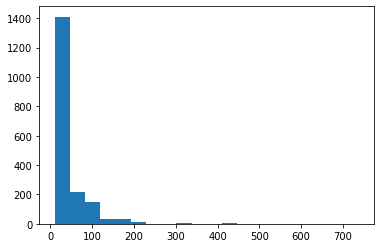

In [31]:
plt.hist(weights_data, bins=20)
plt.show()


The fitted model:

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.9698
Test		0.9698


The model AUC is:

Training	0.8465
Test		0.8465


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0       1872         1.0

TEST
       count  proportion
class                   
0       1872         1.0


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0          1832  40   1872
1             0   0      0
Total      1832  40   1872

TEST
Actual        0   1  Total
Predicted                 
0          1832  40   1872
1             0   0      0
Total      1832 

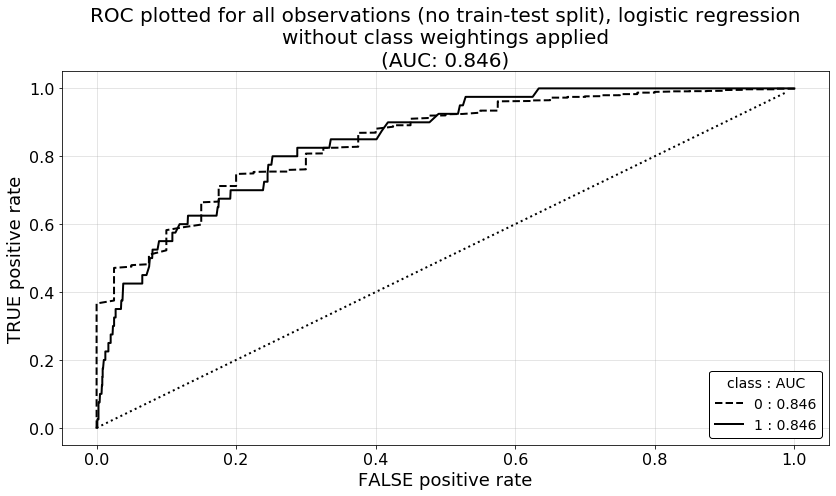

In [34]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight=None

logall_dict = generate_model_dict(
    LogisticRegression,
    X_data,
    y_data,
    X_data,
    y_data,
    class_dict,
    weights_data,
    weights_data,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logall_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)

auc_inputs = [logall_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for all observations (no train-test split), logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.7798
Test		0.7798


The model AUC is:

Training	0.8475
Test		0.8475


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0       1410    0.753205
1        462    0.246795

TEST
       count  proportion
class                   
0       1410    0.753205
1        462    0.246795


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0          1401   9   1410
1           431  31    462
Total      1832  40   1872

TEST
Actual        0   1  Total
Predicted                 
0          140

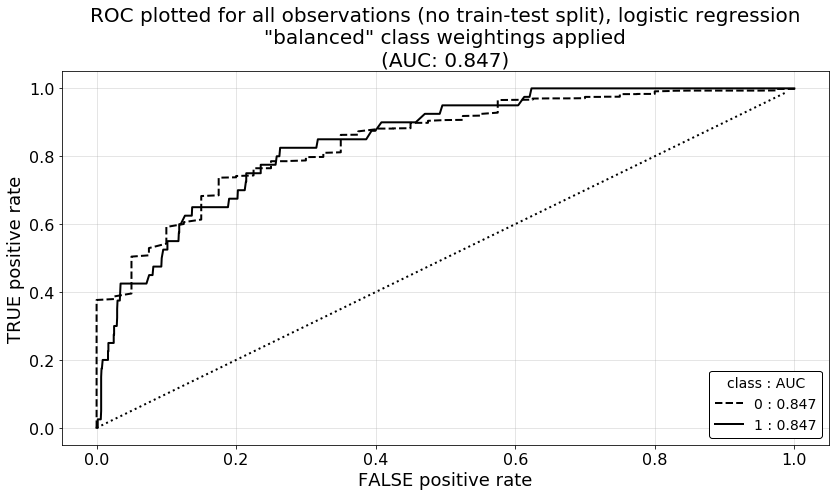

In [35]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight='balanced'

logallbal_dict = generate_model_dict(
    LogisticRegression,
    X_data,
    y_data,
    X_data,
    y_data,
    class_dict,
    weights_data,
    weights_data,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logallbal_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)

auc_inputs = [logallbal_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for all observations (no train-test split), logistic regression\n'\
        '"balanced" class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.7810
Test		0.7810


The model AUC is:

Training	0.8572
Test		0.8572


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0       1442    0.770299
1        430    0.229701

TEST
       count  proportion
class                   
0       1442    0.770299
1        430    0.229701


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0          1432  10   1442
1           400  30    430
Total      1832  40   1872

TEST
Actual        0   1  Total
Predicted                 
0          143

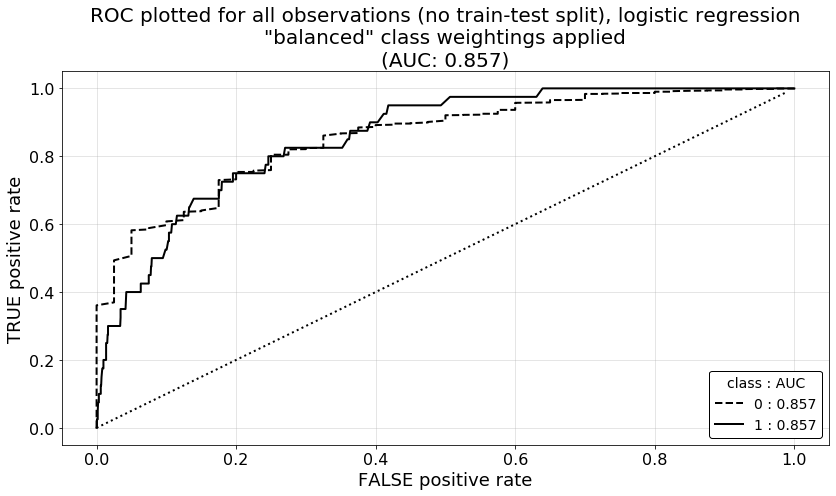

In [40]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight='balanced'

logallbalnw_dict = generate_model_dict(
    LogisticRegression,
    X_data,
    y_data,
    X_data,
    y_data,
    class_dict,
    None,
    None,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logallbalnw_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)

auc_inputs = [logallbalnw_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for all observations (no train-test split), logistic regression\n'\
        '"balanced" class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.9997
Test		0.9997


The model AUC is:

Training	0.7351
Test		0.7351


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
1       1872         1.0

TEST
       count  proportion
class                   
1       1872         1.0


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0             0   0      0
1          1832  40   1872
Total      1832  40   1872

TEST
Actual        0   1  Total
Predicted                 
0             0   0      0
1          1832  40   1872
Total     

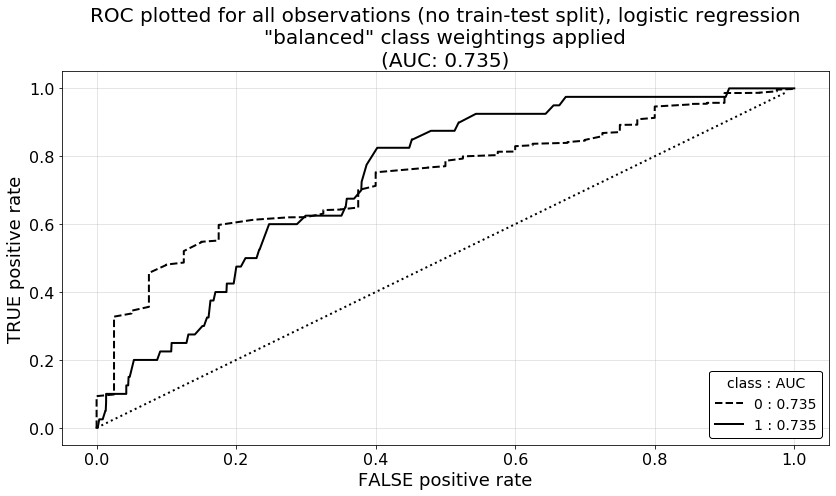

In [41]:
model_2_cols = predictor_cols[2:]
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight='balanced'

logallbal2_dict = generate_model_dict(
    LogisticRegression,
    X_data[model_2_cols],
    y_data,
    X_data[model_2_cols],
    y_data,
    class_dict,
    weights_data,
    weights_data,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logallbal2_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)

auc_inputs = [logallbal2_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for all observations (no train-test split), logistic regression\n'\
        '"balanced" class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.9749
Test		0.9626


The model AUC is:

Training	0.7482
Test		0.8784


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0       1123         1.0

TEST
       count  proportion
class                   
0        749         1.0


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0          1099  24   1123
1             0   0      0
Total      1099  24   1123

TEST
Actual       0   1  Total
Predicted                
0          733  16    749
1            0   0      0
Total      733  16  

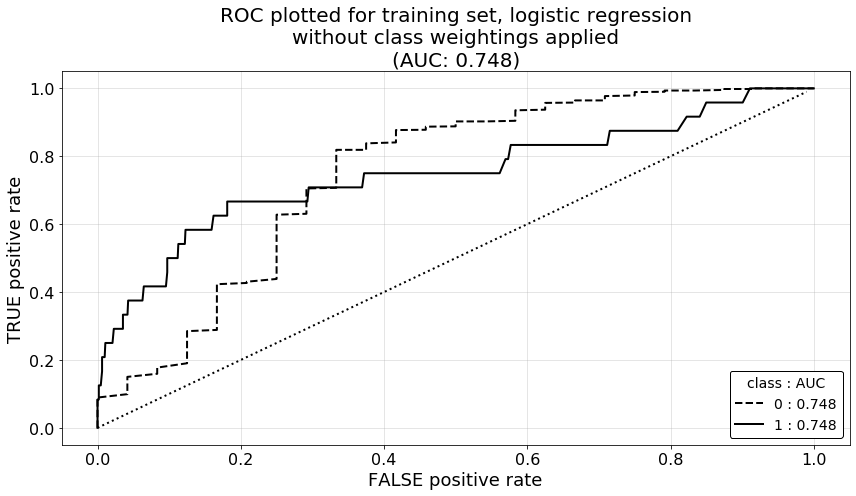

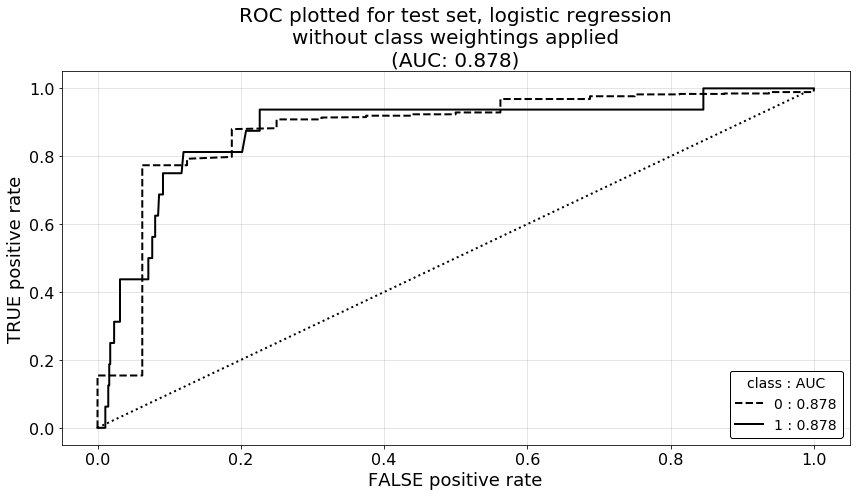

In [49]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight=None

log_dict = generate_model_dict(
    LogisticRegression,
    X_train,
    y_train,
    X_test,
    y_test,
    class_dict,
    weights_train,
    weights_test,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    log_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)

auc_inputs = [log_dict[key]['train'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for training set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)

auc_inputs = [log_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for test set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.7108
Test		0.7549


The model AUC is:

Training	0.7746
Test		0.9023


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
0        888    0.790739
1        235    0.209261

TEST
       count  proportion
class                   
0        577     0.77036
1        172     0.22964


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0           880   8    888
1           219  16    235
Total      1099  24   1123

TEST
Actual       0   1  Total
Predicted                
0          576  

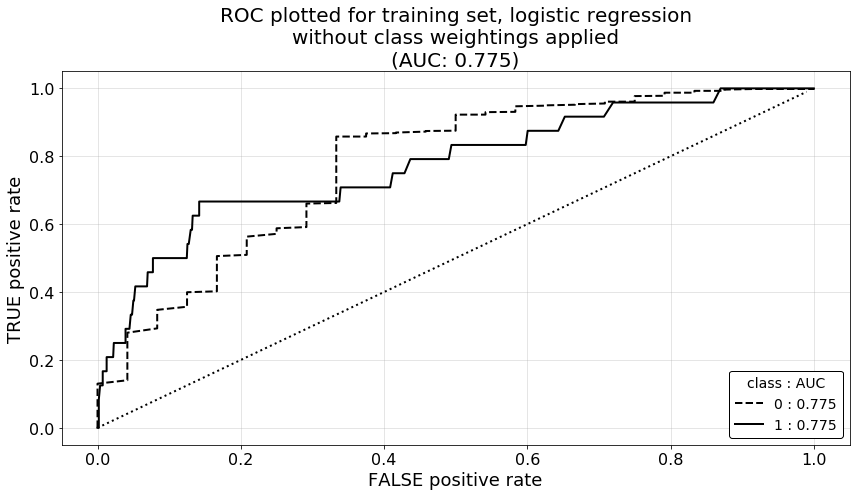

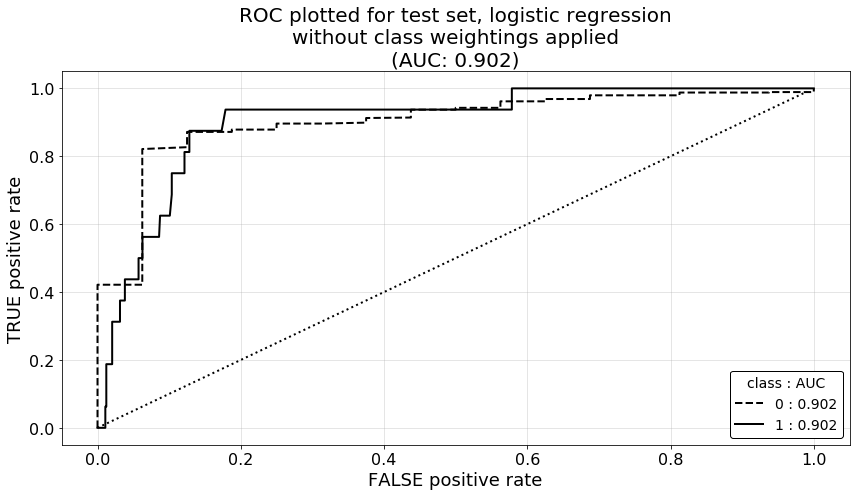

In [50]:
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight='balanced'

logbal_dict = generate_model_dict(
    LogisticRegression,
    X_train,
    y_train,
    X_test,
    y_test,
    class_dict,
    weights_train,
    weights_test,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logbal_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)


auc_inputs = [logbal_dict[key]['train'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for training set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)

auc_inputs = [logbal_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for test set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)


The fitted model:

LogisticRegression(C=100000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=20, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


This model resulted in the following accuracy:

Training	0.9818
Test		0.0374


The model AUC is:

Training	0.6683
Test		0.6980


The number of classes predicted by class are:

TRAINING
       count  proportion
class                   
1       1123         1.0

TEST
       count  proportion
class                   
1        749         1.0


The resulting confusion matrix:

TRAINING
Actual        0   1  Total
Predicted                 
0             0   0      0
1          1099  24   1123
Total      1099  24   1123

TEST
Actual       0   1  Total
Predicted                
0            0   0      0
1          733  16    749
Total      733

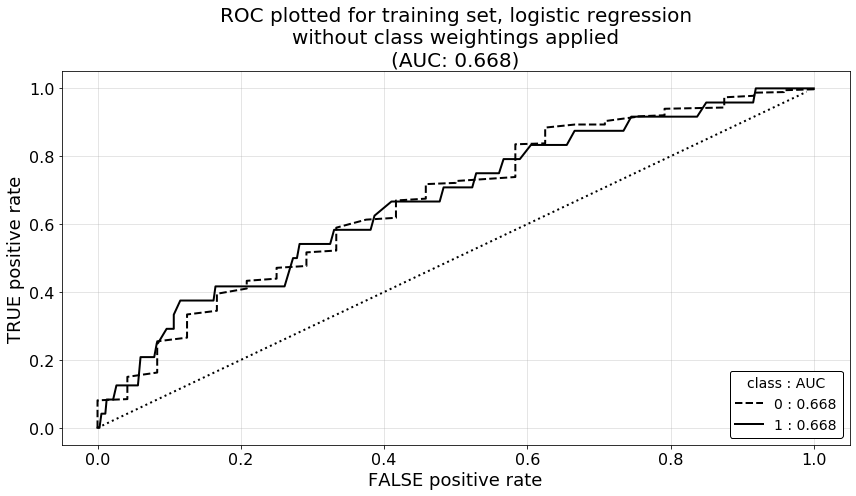

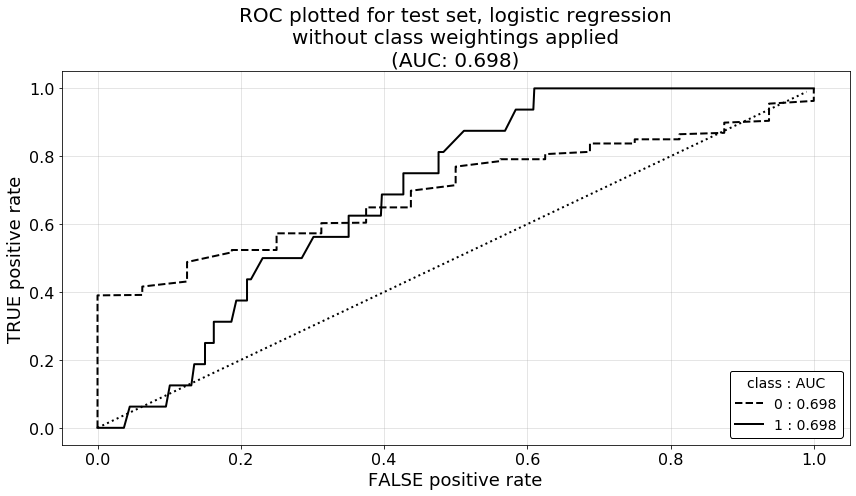

In [51]:
model_2_cols = predictor_cols[2:]
solver = 'lbfgs'
C = 100000
max_iter = 1000

# fit a model again as multinomial for comparison of results
class_weight='balanced'

logbal2_dict = generate_model_dict(
    LogisticRegression,
    X_train[model_2_cols],
    y_train,
    X_test[model_2_cols],
    y_test,
    class_dict,
    weights_train,
    weights_test,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,
)

print_model_results(
    logbal2_dict,accuracy='both', auc='both',
    pred_counts='both', conf_matrix='both',
    class_metrics='both'
)


auc_inputs = [logbal2_dict[key]['train'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for training set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)

auc_inputs = [logbal2_dict[key]['test'] for key in ['auc', 'roc_auc_dict']]

title = 'ROC plotted for test set, logistic regression\n'\
        'without class weightings applied'
savepath = None

plot_roc_all_classes(*auc_inputs, title, savepath)

## Generate bootstrapped coefficient bounds

In [66]:
x_samp, y_samp = resample(X_train, y_train, replace=True, stratify=y_train)

In [144]:
def _generate_coefficients_list(X_train_sample, y_train_sample, **kwargs) -> list:
    """
    Generates a list of estimated coefficients for one bootstrap sample of X_train and y_train
    """
    model = LogisticRegression(**kwargs).fit(X_train_sample, y_train_sample)
    return [model.intercept_[0], *model.coef_[0]]


def _generate_bootstrap_sample(X_train, y_train, stratify=None, n_samples=None, replace=True):
    """
    """
    X_samp, y_samp = resample(
        X_train, y_train, n_samples=n_samples,
        replace=replace, stratify=stratify
    )
    
    return X_samp, y_samp


def _generate_all_bootstrap_samples(iterations, X_train, y_train, stratify=None) -> list:
    """
    Generates a list of sampled indices arrays, one array for each bootstrap iteration
    """
    return [
        _generate_bootstrap_sample(X_train, y_train, stratify=None)
        for iteration in tqdm.tqdm(range(iterations), position=0, desc='generating bootstrap samples', leave=True)
    ]


def _bootstrapped_coefficients_dict(X_train, y_train, iterations, stratify=None, **kwargs) -> dict:
    """
    Generates a dictionary of all bootstrapped coefficients, one key/value pair for
    each iteration of the bootstrap
    """
    return {
        iteration: _generate_coefficients_list(
            X_train_sample = sample_obs[0],
            y_train_sample = sample_obs[1],
            **kwargs
        )
        for iteration, sample_obs
        in zip(
            tqdm.tqdm(range(iterations), position=0, desc='generating coefficients', leave=True),
            _generate_all_bootstrap_samples(iterations, X_train, y_train, stratify)
        )
    }


def make_bootstrap_coefficients_df(X_train,
                                   y_train,
                                   iterations=100,
                                   stratify=None,
                                   **kwargs) -> pd.DataFrame:
    """
    Runs bootstrap and generates a dataframe containing all estimated coefficients,
    one set of coefficients for each bootstrapped sample (i.e. each iteration)
    
    X_train: pd.DataFrame containing predictor training observations
    y_train: pd.DataFrame containing response training observations
    iterations: integer specifying the number of bootstrapped iterations 
    C: float specifying inverse of regularization strength for use with sklearn
       LogisticRegression model
    solver: str specifying the desired solver type for use with sklearn
            LogisticRegression model
    returns: pd.DataFrame of all bootstrapped coefficients
    """
    # create list of coefficient column names for resulting dataframe
    column_names = ['intercept', *X_train.columns]
    
#     # reset indices for input data to protect against index match errors
#     X_train = X_train.reset_index(drop=True)
#     y_train = y_train.reset_index(drop=True)
    
    # generate coefficients dictionary with all bootstrapped sample
    coefficients_dict = _bootstrapped_coefficients_dict(X_train, y_train, iterations, stratify, **kwargs)
    
    return pd.DataFrame.from_dict(coefficients_dict, orient='index', columns=column_names)


def generate_CI_bounds_df(bootstrapped_coefficients_df, significance_level) -> pd.DataFrame:
    """
    Generates dataframe reporting estimated coefficients, lower bounds, upper bouds,
    and observed bootstrapped confidence intervals for each bootstrapped coefficient generated
    using the 'make_bootstrap_coefficients_df' function
    
    bootstrapped_coefficients_df: pd.DataFrame returned using make_bootstrap_coefficients_df
                                  function
    significance_level: float specifying the significance level at which to set lower and
                        upper bounds
    returns: pd.DataFrame reporting CI statistics for each coefficient 
    """
    lower_quantile = significance_level/2
    upper_quantile = 1 - (significance_level/2)
    columns = ['estimated_coeff', 'lower_bound', 'upper_bound']
    return bootstrapped_coefficients_df.quantile(
        [.5, lower_quantile, upper_quantile],
        axis=0,
    ).T.set_axis(
        columns,
        axis=1,
        inplace=False,
    )

def make_bootstrap_model_dicts(iterations, stratify, classifier,
                               X_train, y_train, X_test, y_test,
                               class_dict, **kwargs) -> dict:
    """
    Generates a dictionary of all bootstrapped coefficients, one key/value pair for
    each iteration of the bootstrap
    """
    # reset indices for input data to protect against index match errors
    X_train = X_train.copy().reset_index(drop=True)

    
    return {
        iteration: generate_model_dict(
            classifier,
            *resample(
                X_train, y_train, n_samples=None,
                replace=True, stratify=stratify
            ),
            X_test,
            y_test,
            class_dict,
            **kwargs
        )
        for iteration
        in tqdm.tqdm(
            range(iterations), position=0, desc='generating model dictionaries', leave=True
        )
    }


def make_bootstrap_coef_df(bootstrap_model_dict, X_train) -> pd.DataFrame:
    """
    Generates a dictionary of all bootstrapped coefficients, one key/value pair for
    each iteration of the bootstrap
    """
    column_names = ['intercept', *X_train.columns]
    
    coefficients_dict = {
        iteration: [
            bootstrap_model_dict[iteration]['model'].intercept_[0],
            *bootstrap_model_dict[iteration]['model'].coef_[0]
        ]
        for iteration
        in tqdm.tqdm(range(len(bootstrap_model_dict)), position=0, desc='unpacking coefficients', leave=True)
    }
    
    return pd.DataFrame.from_dict(coefficients_dict, orient='index', columns=column_names)


def make_bootstrap_roc_auc_dict(bootstrap_model_dict, X_train, version="test") -> pd.DataFrame:
    """
    Generates a dictionary of all bootstrapped coefficients, one key/value pair for
    each iteration of the bootstrap
    """
    column_names = ['intercept', *X_train.columns]
    
    auc_dict = {
        iteration: [
            bootstrap_model_dict[iteration]['auc'][version],
        ]
        for iteration
        in range(len(bootstrap_model_dict))
    }
    
    fpr_dict = {
        iteration: [
            bootstrap_model_dict[iteration]['roc_auc_dict'][version][1]['fpr'],
        ]
        for iteration
        in range(len(bootstrap_model_dict))
    }
    
    tpr_dict = {
        iteration: [
            bootstrap_model_dict[iteration]['roc_auc_dict'][version][1]['tpr'],
        ]
        for iteration
        in range(len(bootstrap_model_dict))
    }
    
    thresh_dict = {
        iteration: [
            bootstrap_model_dict[iteration]['roc_auc_dict'][version][1]['thresh'],
        ]
        for iteration
        in range(len(bootstrap_model_dict))
    }

    auc_df = pd.DataFrame.from_dict(auc_dict, orient='index', columns=['auc']) 
    
    return pd.DataFrame.from_dict(coefficients_dict, orient='index', columns=column_names)


def make_bootstrap_coefficients_df(X_train,
                                   y_train,
                                   iterations=100,
                                   stratify=None,
                                   **kwargs) -> pd.DataFrame:
    """
    Runs bootstrap and generates a dataframe containing all estimated coefficients,
    one set of coefficients for each bootstrapped sample (i.e. each iteration)
    
    X_train: pd.DataFrame containing predictor training observations
    y_train: pd.DataFrame containing response training observations
    iterations: integer specifying the number of bootstrapped iterations 
    C: float specifying inverse of regularization strength for use with sklearn
       LogisticRegression model
    solver: str specifying the desired solver type for use with sklearn
            LogisticRegression model
    returns: pd.DataFrame of all bootstrapped coefficients
    """
    # create list of coefficient column names for resulting dataframe
    column_names = ['intercept', *X_train.columns]
    
    # reset indices for input data to protect against index match errors
    X_train = X_train.copy().reset_index(drop=True)
    
    # generate coefficients dictionary with all bootstrapped sample
    coefficients_dict = _bootstrapped_coefficients_dict(X_train, y_train, iterations, stratify, **kwargs)
    
    return pd.DataFrame.from_dict(coefficients_dict, orient='index', columns=column_names)


def make_save_load_boostrap_model_dict(dict_name, target_directory,
                                       classifier, X_train, X_test, y_train, y_test,
                                       class_dict, verbose=False, roc_auc=True,
                                       overwrite=False, **kwargs):
    """
    Prior to running the generate_model_dict() function, this first
    checks to determine whether a saved copy of the specified model has
    already been saved to the specified path. 
    
    If no saved dict file is found the function calls generate_model_dict()
    and saves the resulting dictionary to the specified filepath.
    
    If a saved dict file does exist, the function simply loads that file
    instead of running the model again.
    
    NOTE: the resulting target filepath used for saving/checking for the resulting
          model_dict is generated as:
            
            os.path.join(target_directory, ''.join([model_dict_name, '.joblib']))
    
    model_dict_name: str, specifies the desired name of the model dict object you wish
                to generate
    target_directory: str, the directory path in which you wish to save or check for
                      the resulting model
    classifier: the uninitiated sklearn classification model object you wish
           to use (e.g. LogisticRegression, KNeighborsClassifier)
    X_train, X_test, y_train, y_test: the datasets on which to fit and
                                      evaluate the model
    class_dict: dict, key values must be the class number (i.e 0, 1, 2, ...) and
                the corresponding values must be the class name string (i.e. 'other',
                'burlary', ...) for each respective class number
    verbose: if True prints resulting fitted model object
    roc_auc: if True calculates and stores roc and auc dictionaries for both train
             and test
    overwrite: bool, default=False, if True, generate_model_dict() will generate a new
               dictionary regardless of whether or not the target filepath already
               exists and overwrite any file that already exists at the specified
               filepath
    **kwargs: are optional classifier-specific arguments that pass directly to the model
              while fitting

    returns: dict, dictionary object containing the resulting fitted model object,
             resulting predictions, predicted probabilities, prediction count summary tables,
             confusion matrices, accuracy scores, and (if roc_auc=True) the AUC, weighted AUC,
             and ROC AUC dictionary for both the training and test sets
    """
    filepath = os.path.join(target_directory, ''.join([dict_name, '.joblib']))
    
    if os.path.exists(filepath) and not overwrite:
        locals()[dict_name] = joblib.load(filepath)
        print(
            '\nThe model dictionary already exists and has been LOADED from:'\
            '\n\n\t{}\n'.format(filepath)
        )
    else:
        locals()[dict_name] = generate_model_dict(
            classifier,
            X_train,
            X_test,
            y_train,
            y_test,
            class_dict,
            verbose,
            roc_auc,
            **kwargs
        )
        dump_loc = joblib.dump(locals()[dict_name], filepath)
        print(
            '\nThe new model dictionary has been generated and SAVED to disk at:'\
            '\n\n\t{}\n'.format(dump_loc[0])
        )
    
    return locals()[dict_name]


In [154]:
%%time

iterations = 10000

logbal_boostrap_dict = make_bootstrap_model_dicts(
    iterations,
    y_train,
    LogisticRegression,
    X_train, y_train,
    X_test, y_test,
    class_dict,
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,    
)

generating model dictionaries: 100%|██████████| 10000/10000 [07:30<00:00, 22.18it/s]


CPU times: user 29min 33s, sys: 26.5 s, total: 30min
Wall time: 7min 30s


In [186]:
pd.DataFrame(np.hstack(
    [
        logbal_boostrap_dict[0]['roc_auc_dict']['test'][1]['fpr'].reshape(-1,1),
        logbal_boostrap_dict[0]['roc_auc_dict']['test'][1]['tpr'].reshape(-1,1),
        logbal_boostrap_dict[0]['roc_auc_dict']['test'][1]['thresholds'].reshape(-1,1),
    ]
), columns=['fpr', 'tpr', 'thresholds'])

,fpr,tpr,thresholds
0,0.000000,0.0000,1.994823
1,0.001364,0.0000,0.994823
2,0.005457,0.0000,0.986394
3,0.005457,0.0625,0.984024
4,0.006821,0.0625,0.977873
...,...,...,...
197,0.984993,1.0000,0.026517
198,0.987722,1.0000,0.022723
199,0.991814,1.0000,0.020930
200,0.997271,1.0000,0.019364


In [177]:
np.array([
    logbal_boostrap_dict[iteration]['roc_auc_dict']['test'][1]['fpr']
    for iteration in range(len(logbal_boostrap_dict))
]).shape


(10000,)

In [195]:
fpr_test_df = pd.DataFrame.from_dict({
    iteration: [
        *logbal_boostrap_dict[iteration]['roc_auc_dict']['test'][1]['fpr'],
    ]
    for iteration
    in range(len(logbal_boostrap_dict))
}, orient='index')

tpr_test_df = pd.DataFrame.from_dict({
    iteration: [
        *logbal_boostrap_dict[iteration]['roc_auc_dict']['test'][1]['tpr'],
    ]
    for iteration
    in range(len(logbal_boostrap_dict))
}, orient='index')

In [196]:
tpr_test_df.mean(axis=0)

0      0.000000
1      0.001350
2      0.034844
3      0.062906
4      0.094387
         ...   
227    1.000000
228    1.000000
229    1.000000
230    1.000000
231    1.000000
Length: 232, dtype: float64

In [207]:
fpr_test_df.mean(axis=0, skipna=True)

0      0.000000
1      0.001371
2      0.002548
3      0.005170
4      0.006992
         ...   
227    0.989768
228    0.994088
229    0.995907
230    0.998181
231    1.000000
Length: 232, dtype: float64

In [200]:
fpr_test_df.iloc[0, :]

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.0,0.001364,0.005457,0.005457,0.006821,0.009550,0.012278,0.015007,0.015007,0.017735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.001364,0.001364,0.009550,0.012278,0.017735,0.020464,0.020464,0.023192,0.025921,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.001364,0.001364,0.008186,0.008186,0.009550,0.009550,0.012278,0.013643,0.013643,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,0.002729,0.005457,0.005457,0.012278,0.012278,0.013643,0.016371,0.016371,0.023192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,0.001364,0.002729,0.005457,0.005457,0.008186,0.008186,0.012278,0.012278,0.017735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.001364,0.002729,0.002729,0.008186,0.008186,0.009550,0.012278,0.015007,0.015007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9996,0.0,0.001364,0.002729,0.005457,0.005457,0.006821,0.006821,0.008186,0.008186,0.009550,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9997,0.0,0.001364,0.004093,0.006821,0.006821,0.013643,0.016371,0.020464,0.020464,0.023192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9998,0.0,0.001364,0.002729,0.002729,0.005457,0.005457,0.008186,0.008186,0.012278,0.015007,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


100%|██████████| 10000/10000 [01:00<00:00, 164.90it/s]


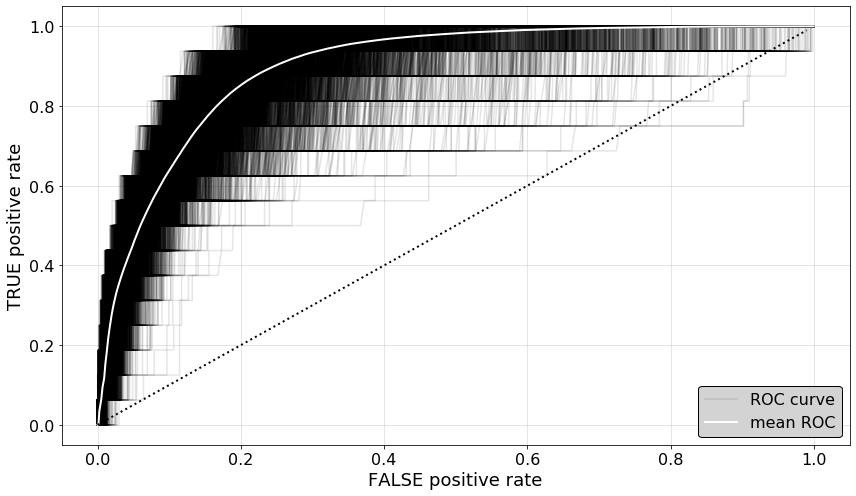

In [216]:
fig, ax = plt.subplots(figsize=(12, 7))

for i in tqdm.tqdm(range(len(fpr_test_df)), position=0):
    plt.plot(fpr_test_df.iloc[i, :], tpr_test_df.iloc[i, :], color='k', alpha=0.1, label='ROC curve' if i==0 else None)

plt.plot(fpr_test_df.mean(axis=0), tpr_test_df.mean(axis=0), color='white', linewidth=2, alpha=1, label='mean ROC')

rate_values=np.arange(0,100)/100

ax.plot(rate_values, rate_values, ':', color='k', linewidth=2, alpha=1)

plt.legend(edgecolor='k', facecolor='lightgray', framealpha=1, loc=4, fontsize=16)
ax.tick_params(labelsize=16)
ax.set_ylabel("TRUE positive rate", fontsize=18)
ax.set_xlabel("FALSE positive rate", fontsize=18)
ax.grid(':', alpha=0.4)
plt.tight_layout()
plt.show();

In [173]:
logbal_boostrap_dict[0]['roc_auc_dict']['test'][1]['fpr']

array([0.        , 0.00136426, 0.00545703, 0.00545703, 0.00682128,
       0.0095498 , 0.01227831, 0.01500682, 0.01500682, 0.01773533,
       0.01773533, 0.02046385, 0.02046385, 0.03547067, 0.03547067,
       0.04092769, 0.04365621, 0.04502046, 0.05047749, 0.053206  ,
       0.053206  , 0.05729877, 0.05729877, 0.06002729, 0.06002729,
       0.07094134, 0.07094134, 0.07503411, 0.08049113, 0.08594816,
       0.08594816, 0.08867667, 0.09686221, 0.09959072, 0.10231924,
       0.10504775, 0.10914052, 0.11050477, 0.11323329, 0.11459754,
       0.11732606, 0.13096862, 0.13369714, 0.13506139, 0.13642565,
       0.13915416, 0.14324693, 0.1473397 , 0.15279673, 0.15552524,
       0.15825375, 0.16371078, 0.16643929, 0.1691678 , 0.17462483,
       0.17735334, 0.18008186, 0.18281037, 0.19099591, 0.19508868,
       0.20327422, 0.2100955 , 0.21691678, 0.22100955, 0.22510232,
       0.22510232, 0.22646658, 0.2319236 , 0.24283765, 0.24556617,
       0.25102319, 0.25375171, 0.25648022, 0.26193724, 0.26603

In [155]:
df_coefs = make_bootstrap_coef_df(logbal_boostrap_dict, X_train)

unpacking coefficients: 100%|██████████| 10000/10000 [00:00<00:00, 336392.03it/s]


In [156]:
generate_CI_bounds_df(df_coefs, significance_level=0.05)

,estimated_coeff,lower_bound,upper_bound
intercept,2.002425,-0.493434,4.646526
CPay,1.180589,0.103598,2.212302
MBank,2.160643,0.883911,3.352663
EdLevel,-0.471410,-0.971577,0.005994
IncLevel,0.015047,-0.296129,0.280883
AgeLevel,-0.307410,-0.710947,0.076614
white,-0.477156,-1.694271,1.466505


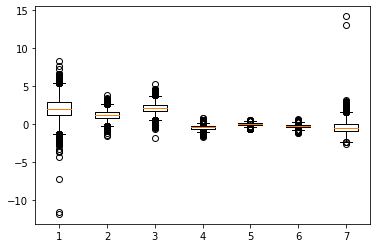

In [157]:
plt.boxplot(df_coefs.T)
plt.show();

In [118]:
%%time

iterations = 10000

df_coefs = make_bootstrap_coefficients_df(
    X_train, y_train,
    iterations=iterations,
    stratify=y_train, 
    C=C,
    solver=solver,
    max_iter=max_iter,
    class_weight=class_weight,
    random_state=20,    
)

generating coefficients: 100%|██████████| 10000/10000 [01:33<00:00, 106.93it/s]

CPU times: user 5min 57s, sys: 4.66 s, total: 6min 2s
Wall time: 1min 33s


In [123]:
generate_CI_bounds_df(df_coefs, significance_level=0.05)

,estimated_coeff,lower_bound,upper_bound
intercept,2.010621,-0.625518,4.721201
CPay,1.183353,0.048029,2.285995
MBank,2.153397,0.878441,3.400374
EdLevel,-0.472853,-0.999772,0.014316
IncLevel,0.014403,-0.321288,0.290293
AgeLevel,-0.308330,-0.734689,0.095273
white,-0.471306,-1.765940,1.602021


In [75]:
[logbal_dict['model'].intercept_[0], *logbal_dict['model'].coef_[0]]

[2.0357905270183947,
 1.150286543790109,
 2.0433145540861335,
 -0.43359954048814453,
 0.01603297386659204,
 -0.28962071798643096,
 -0.4928837018909682]

In [ ]:
def _generate_coefficients_list(X_train_sample, y_train_sample, C, solver) -> list:
    """
    Generates a list of estimated coefficients for one bootstrap sample of X_train and y_train
    """
    model = LogisticRegression(C=C, solver=solver).fit(X_train_sample, y_train_sample)
    return [model.intercept_[0], *model.coef_[0]]

def _generate_sample_indices(indices) -> np.ndarray:
    """
    Generates and array of sampled indices, representing values sampled during a single
    iteration of the bootstrap
    """
    return np.random.choice(a=indices, size=len(indices), replace=True)

def _generate_all_sample_indices(indices, iterations) -> list:
    """
    Generates a list of sampled indices arrays, one array for each bootstrap iteration
    """
    return [
        _generate_sample_indices(indices) for iteration in range(iterations)
    ]
    
def _bootstrapped_coefficients_dict(X_train, y_train, iterations, C, solver) -> dict:
    """
    Generates a dictionary of all bootstrapped coefficients, one key/value pair for
    each iteration of the bootstrap
    """
    return {
        iteration: _generate_coefficients_list(
            X_train_sample = X_train.iloc[sample_indices],
            y_train_sample = y_train.iloc[sample_indices],
            C=C,
            solver=solver
        )
        for iteration, sample_indices
        in zip(range(iterations), _generate_all_sample_indices(X_train.index, iterations))
    }

def make_bootstrap_coefficients_df(X_train,
                                   y_train,
                                   iterations=100,
                                   C=100000,
                                   solver='liblinear') -> pd.DataFrame:
    """
    Runs bootstrap and generates a dataframe containing all estimated coefficients,
    one set of coefficients for each bootstrapped sample (i.e. each iteration)
    
    X_train: pd.DataFrame containing predictor training observations
    y_train: pd.DataFrame containing response training observations
    iterations: integer specifying the number of bootstrapped iterations 
    C: float specifying inverse of regularization strength for use with sklearn
       LogisticRegression model
    solver: str specifying the desired solver type for use with sklearn
            LogisticRegression model
    returns: pd.DataFrame of all bootstrapped coefficients
    """
    # create list of coefficient column names for resulting dataframe
    column_names = ['intercept', *X_train.columns]
    
    # reset indices for input data to protect against index match errors
    X_train = X_train.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    
    # generate coefficients dictionary with all bootstrapped sample
    coefficients_dict = _bootstrapped_coefficients_dict(X_train, y_train, iterations, C, solver)
    
    return pd.DataFrame.from_dict(coefficients_dict, orient='index', columns=column_names)


def generate_CI_bounds_df(bootstrapped_coefficients_df, significance_level) -> pd.DataFrame:
    """
    Generates dataframe reporting estimated coefficients, lower bounds, upper bouds,
    and observed bootstrapped confidence intervals for each bootstrapped coefficient generated
    using the 'make_bootstrap_coefficients_df' function
    
    bootstrapped_coefficients_df: pd.DataFrame returned using make_bootstrap_coefficients_df
                                  function
    significance_level: float specifying the significance level at which to set lower and
                        upper bounds
    returns: pd.DataFrame reporting CI statistics for each coefficient 
    """
    lower_quantile = significance_level/2
    upper_quantile = 1 - (significance_level/2)
    columns = ['estimated_coeff', 'lower_bound', 'upper_bound']
    return bootstrapped_coefficients_df.quantile(
        [.5, lower_quantile, upper_quantile],
        axis=0,
    ).T.set_axis(
        columns,
        axis=1,
        inplace=False,
    )
    

def identify_significant_coefs_df(bootstrapped_coefficients_df, significance_level=0.05) -> pd.DataFrame:
    """
    Identifies significant coefficients using confidence intervals generated via the
    make_bootstrap_coefficients_df function
    
    bootstrapped_coefficients_df: pd.DataFrame returned using make_bootstrap_coefficients_df
                                  function
    significance_level: float, default=0,05 specifying the significance level at which to set
                        lower and upper bounds
    returns: pd.DataFrame, similar to output from generate_CI_bounds_df function, but subsetted
             to include only coefficients identified as significant at the specified significance
             level
    """
    coefs_CI_df = generate_CI_bounds_df(bootstrapped_coefficients_df, significance_level)
    coefs_CI_df['significant'] = (coefs_CI_df['lower_bound'] > 0) | (coefs_CI_df['upper_bound'] < 0) 
    return coefs_CI_df